# Background:

*_"Image segmentation is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects." - Wikipedia_*

Simply put, in image segmentation, the goal is to classify the discrete group of pixels into a particular class, marked by a particular color. This representation of image may prove to be meaningful than the original image since they are easier to notice and analyze.

Medical imaging allows healthcare professionals to view the inside of a human body for diagnostic and treatment purposes. However, a critical challenge within this field is not just obtaining these images but also interpreting them with accuracy and consistency. This is where image segmentation becomes essential. In medical imaging segmentation, computers are used to classify pixels into particular regions, like separating tissues, organs, or abnormalities, allowing more meaningful insights compared to viewing raw images.

One key area of application is in the diagnosis of diseases affecting the GI (Gastrointestinal) tract. Usually, endoscopy is used for disease surveillance and inflammation monitoring. Endoscopic image analysis has gained more attention, thanks to computer-aided detection.  Automatic detection of abnormalities such as polyp (inflammation) by algorithms could transform the diagnosis process by aiding doctors.

In this notebook, we have introduced the Kvasir dataset, which contains a thousand annotated images collected from endoscopic examinations. The images capture anatomical landmarks such as pylorus, as well as pathological findings like polyps and esophagitis. Polyps are a type of tumor that grows out of mucous lining, such as the mucosa of intenstines. Expert medical doctors have thoroughly annotated these images. A segmentation model is to be trained on these images which can successfully segment the image by generating a binary(black and white) mask, where the white region implies the presence of polyp.



<center>

<img src="https://drive.google.com/uc?export=view&id=1KEkxjiukwt4n3A6FDH7hgWjNQ7-I40UB" alt="This figure depicts that a segmentation model generates semantic mask." height="200" width="600">

Fig: Semantic Segmentation of Images

</center>


A powerful deep learning model used in the medical image segmentation is the `U-Net`. This convolutional neural network (CNN) excels at segmenting the images by learning both low-level features (shape and texture) as well as high-level features (identifying a particular structure in the image). When trained on datasets like Kvasir, U-Net can be highly effective in predicting the areas at risk of cancerous development.


<center>

<img src="https://drive.google.com/uc?export=view&id=1Kfbx_AYq8ARdtCdiHaNYB-jeWl9MnzqH" alt="This figure depicts U-Net architecture in detail." height="900" width="1000">

Fig: U-Net Architecture

</center>

## Tools and Libraries Used:

1. `draw.io`: A web-based tool used for creating diagrams, it is used for representing/drawing the U-Net architecture.

2. `numpy`: A fundamental Python library for numerical computing, which is used in various operations such as to convert the tensors to numpy arrays, calculating the mean of the array, raveling the array for histogram,etc.

3. `matplotlib`: A widely used plotting library, which is used to visualize image data, including heatmaps, histograms, and masks.

4. `torch`: The core library for PyTorch, responsible for creating and manipulating tensors, defining models, applying gradients, and performing training and inference.

5. `torchvision`: A PyTorch library providing utilities for computer vision tasks, such as image loading, transformation, and augmentation. Here it helps with loading the Kvasir dataset, applying transformations like resizing and normalization.

6. `PIL`: A python imaging library used for handling and manipulating images. Here, the images in Kvasir dataset are opened using PilImage alias.

7. `tqdm`: A library used for displaying progress bars during loops. Here, it is used to track the progress of model training, particularly for tracking the number of epochs and batches processed.

# Steps:

## Step 1: Dataset Preparation:

This step involves parsing the images and masks by applying the necessary transformation (such as resize). We do so by defining a custom dataset class and writing the methods for getting the images, applying the transformation and returning them. This step also involves the preparation of train, test and validations set, which are required for the training, validation and evaluation of the model respectively.


In [ ]:
import os
from PIL import Image as PilImage
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
from torchvision.io import read_image
import torchvision.transforms.functional as TF
import numpy as np

### 1.a. Class Definition:

Lets define custom dataset class `KvasirDataset` which inherits from torch.utils.data.Dataset.

In [ ]:
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Use PIL to open the images
        image = PilImage.open(img_path).convert("RGB")
        mask = PilImage.open(mask_path).convert("L")  # Convert mask to grayscale

        # Apply the transformations if available
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

The test dataset consists of only images (not masks), so lets create a separate class to parse and return the image.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = PilImage.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

### 1.b.  Transformation definition on the data:

This is one of the arguments to initialize the dataset from the above class.

In [ ]:
# transforms1 = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((256,256)),
#     interpolation=PilImage.NEAREST
# ])

In [ ]:
# Binary masks should use nearest neighbor interpolation to preserve values (0, 1)
transforms1 = transforms.Compose([
    transforms.Resize((256, 256), interpolation=PilImage.NEAREST),  # Nearest neighbor for masks
    transforms.ToTensor(),
])


###1.c. Dataset Instantiation:

Lets instantiate the dataset and test dataset from the above class.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/naamii

 Classification.png	        saved_model	  UNet.png
 data			        test_data	 'Virtual Try-On Using Generative Modeling.pptx'
'Kvasir Segmentation.gslides'   unet.drawio.png
'Music generation.ppx'	        unet_full.png


In [ ]:
dataset = KvasirDataset(
    images_dir = "/content/drive/MyDrive/naamii/data/images",
    masks_dir = "/content/drive/MyDrive/naamii/data/masks",
    transform = transforms1,
    target_transform = transforms1)

In [ ]:
total_data = len(dataset)
print(total_data)

1000


Lets instantiate test dataset using the above TestDataset class.

In [ ]:
test_dataset = TestDataset(
    images_dir = "/content/drive/MyDrive/naamii/test_data/images",
    transform = transforms1)

In [ ]:
test_data = len(test_dataset)
print(test_data)

160


###1.d. Train-Validation Split:

Lets create train dataset and validation dataset from the dataset available. (We will use the dataset in a separate folder for the test set).

We will use the following:

`torch.utils.data.random_split(dataset, lengths, generator=<torch._C.Generator object>)`

In [ ]:
train_size = int(0.8 * total_data)
val_size = total_data - train_size
print(train_size)
print(val_size)

800
200


In [ ]:
import torch.utils.data as data

dataset_train, dataset_val = data.random_split(dataset, [train_size, val_size])

print(len(dataset_train))
print(len(dataset_val))

800
200


In [ ]:
print(len(test_dataset))

160


###1.e. DataLoader:

Lets create a dataloader now using batch size of 16. This will load 16 samples of data per batch from `dataset_train`. The parameter shuffle, if set to True (default = False) will reshuffle data at every epoch.

Reference: [https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader]


In [ ]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size = 4)
dataloader_val = DataLoader(dataset_val, batch_size=4)

In [ ]:
dataloader_test = DataLoader(test_dataset, batch_size = 4)

In [ ]:
len(dataloader_val)

50

In [ ]:
len(dataloader_test)

40

## Step 2:  Exploratory Data Analysis (EDA):

This step involves exploring the dataset to know more about the data. For images, visual inspection is usually the go-to approach. In addition to that, the heatmap, histogram and the shape of the images can be visualized.

Thus, Lets explore the dataset and visualize them.

In [ ]:
for images, masks in dataloader_train:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break  # Display the first batch only

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


In [ ]:
for images in dataloader_test:
    print(f"Image batch shape: {images.shape}")
    break  # Display the first batch only

Image batch shape: torch.Size([4, 3, 256, 256])


Lets plot the image and mask with their respective histograms and heatmap of image to visualize them.
* Lets convert the tensors to pil image for visualization.
* Images need to be converted to numpy format to use matplotlib.pyplot.hist method. Reference: [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html]
* Heatmap represents pixel intensity values across the image. It can help identify areas with different densities. Note that it's not necessary to convert tensor image to pil format to use sns.heatmap.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import seaborn as sns

def display_figures(image_tensor, mask_tensor, idx):
    image_pil = TF.to_pil_image(image_tensor)
    mask_pil = TF.to_pil_image(mask_tensor)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Image {idx + 1}")
    plt.imshow(image_pil)

    # plt.subplot(1, 4, 2)
    # plt.title(f"Image {idx + 1} Histogram")
    # image_np = np.array(image_pil)
    # plt.hist(image_np.ravel(), bins=256, color='blue')

    plt.subplot(1, 2, 2)
    plt.title(f"Mask {idx + 1}")
    plt.imshow(mask_pil, cmap='gray')

    # plt.subplot(1, 4, 4)
    # plt.title(f"Mask {idx + 1} Histogram")
    # mask_np = np.array(mask_pil)
    # plt.hist(mask_np.ravel(), bins=256, color='blue')

    plt.show()

Lets visualize the images and masks of 2 images in train set.

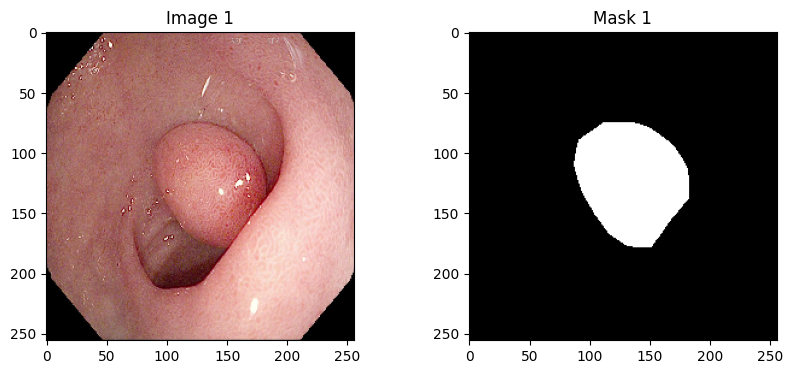

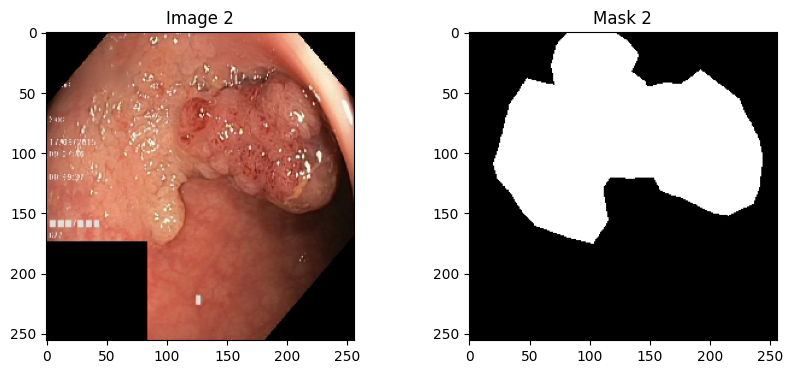

In [ ]:
train_images, train_masks = next(iter(dataloader_train))

for i in range(2):
    display_figures(train_images[i], train_masks[i], i)

Lets visualize the images and masks of the validation set as well.

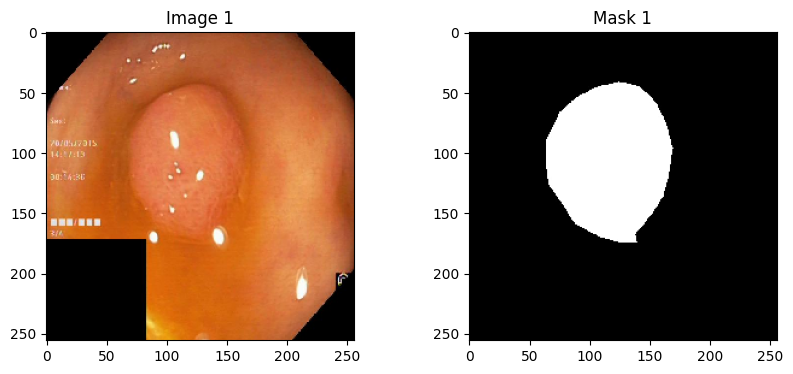

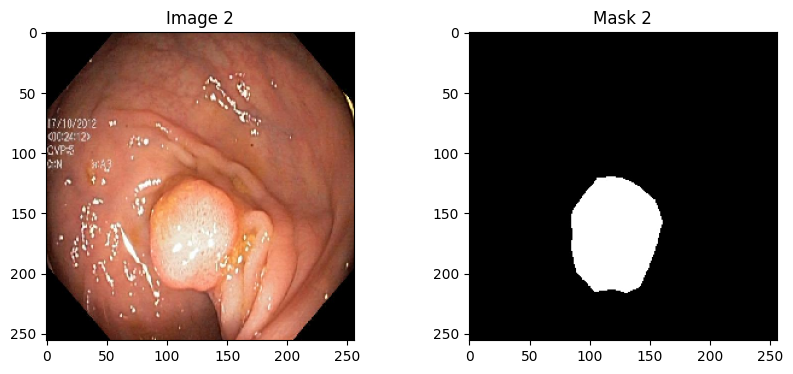

In [ ]:
val_images, val_masks = next(iter(dataloader_val))

for i in range(2):
    display_figures(val_images[i], val_masks[i], i)

In [ ]:
print(val_images.shape)

torch.Size([4, 3, 256, 256])


In [ ]:
print(val_masks.shape)

torch.Size([4, 1, 256, 256])


## Step 3: Model architecture:

Segmentation task requires an encoder-decoder like architecture, because the encoder part has to capture hierarchical high-level features and the decoder part recovers the spatial details to predict pixel-wise classification.

U-Net fulfills this requirement by using an Encoer-Decoder structure with skip connections. The skip connection is an additional component that helps preserve spatial information for the decoder to recover.

Since we resized our image to 256x256, the spatial dimension changes accordingly. For that reason, let's draw the U-Net architecture with the modified image size(256x256) provided as input. (In the official paper, image of size 572x572 was supplied as an input!)  The following figure consists exactly that.


<center>

<img src="https://drive.google.com/uc?export=view&id=1Kfbx_AYq8ARdtCdiHaNYB-jeWl9MnzqH" alt="This figure depicts U-Net architecture in detail." height="1000" width="1000">

Fig: U-Net Architecture

</center>

###3.a. Contracting Path in UNet (First half of U shape):

We will be using `double convolution` (a convolution block or Dual convolution) before downsampling.
* The convolution performed for the first time in the dual convolution decreases the spatial dimension and increases the feature dimension.
* The convolution performed for the second time in the dual convolution doesn't change the feature channel size. Only the spatial size is reduced.

The spatial dimension is halved by `Max Pooling`, which is applied after double convolution.

###3.b. Expansion Path in UNet (Second half of U shape):

The `up-conv 2x2` implies the upward convolution or transpose2d convolution which increases the spatial dimension and reduces the feature channel dimension.

The decoder part also uses `double convolution` but here the operation is reverse to that of Encoder. i.e The goal is to increase the spatial dimension and reduce the feature dimension.

The final part consists of convolution using `1x1` kernel size, which doesn't change the spatial dimension. The final number of channels is specified as the parameter 'output_channels`. For example, if the segmentation map is to be made grayscale, then specify output_channels=1 in the parameter of the final 1x1 convolution.





In [ ]:
import torch
import torch.nn as nn
import torchvision

Lets create a function called double_convolution which can be resued in the UNet architecture.

As per the PyTorch documentation, various methods and their corresponding arguments are listed below:


1. `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

2. `torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)`

3. `torch.nn.ReLU(inplace = True)` Here the parameter is a `bool` which if true, modifies the input tensor directly without allocating new memory.  

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),
  )

  return conv

**Note that during the concatenation operation in UNet architecture, there may be mismatch in tensor sizes**

This happens because of tensor size of down-sampling path and up-sampling path may not match always because convolution and pooling layers tend to change spatial dimension.
We can:
1. Either do padding in convolution and then concatenate
2. Or crop and concatenate.

Lets create a function for cropping the spatial dimensions.

In [ ]:
import torch.nn.functional as F

In [ ]:
# def center_crop(enc_feature, dec_feature):
#   _, _, h, w = dec_feature.size()
#   enc_feature = F.interpolate(enc_feature, size=(h,w), mode="bilinear", align_corners=False)
#   return enc_feature

In [ ]:
def center_crop(enc_feature, dec_feature):
    _, _, h, w = dec_feature.size()  # Get the height and width of the decoder feature map
    enc_feature = torchvision.transforms.CenterCrop([h, w])(enc_feature)  # Crop encoder feature
    return enc_feature

Lets create the Model Architecture now.

There are 4 main units:
1. Encoder: Double convolution with increasing channels
2. Downsampling: Maxpooling

3. Upsampling: Transpose Convolution
4. Decoder: (Concatenation and then) Double convolution with decreasing channels

**Note that since `double_conv` and `center_crop` are not static functions inside the class, we call it without using self.**

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet,self).__init__()

    self.enc1 = double_conv(in_channels, 64)
    self.enc2 = double_conv(64,128)
    self.enc3 = double_conv(128,256)
    self.enc4 = double_conv(256,512)
    self.enc5 = double_conv(512,1024)

    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.dec1 = double_conv(1024,512)
    self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.dec2 = double_conv(512,256)
    self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.dec3 = double_conv(256,128)
    self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.dec4 = double_conv(128,64)

    self.out = nn.Conv2d(64, out_channels, kernel_size = 1)


  def forward(self, x):
    x1 = self.enc1(x)
    x2 = self.enc2(self.pool(x1))
    x3 = self.enc3(self.pool(x2))
    x4 = self.enc4(self.pool(x3))
    x5 = self.enc5(self.pool(x4))

    x = self.trans1(x5)
    x = center_crop(x,x4)
    x = torch.cat([x,x4], dim=1)
    x = self.dec1(x)

    x = self.trans2(x)
    x = center_crop(x,x3)
    x = torch.cat([x,x3], dim=1)
    x = self.dec2(x)

    x = self.trans3(x)
    x = center_crop(x,x2)
    x = torch.cat([x,x2], dim=1)
    x = self.dec3(x)

    x = self.trans4(x)
    x = center_crop(x,x1)
    x = torch.cat([x,x1], dim=1)
    x = self.dec4(x)

    x = self.out(x)

    return(x)

###3.c. Model Instantiation:

The number of in_channels and out_channels have to be specified because the constructor in the above class requires these.

In [ ]:
model = UNet(in_channels=3, out_channels=1)

In [ ]:
model

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

###3.d. Model Visualization:

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=7bb56e194ba07e5ea1e77f4360fdfea3ead6e8eb1779d3110653d5fcb518b15e
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


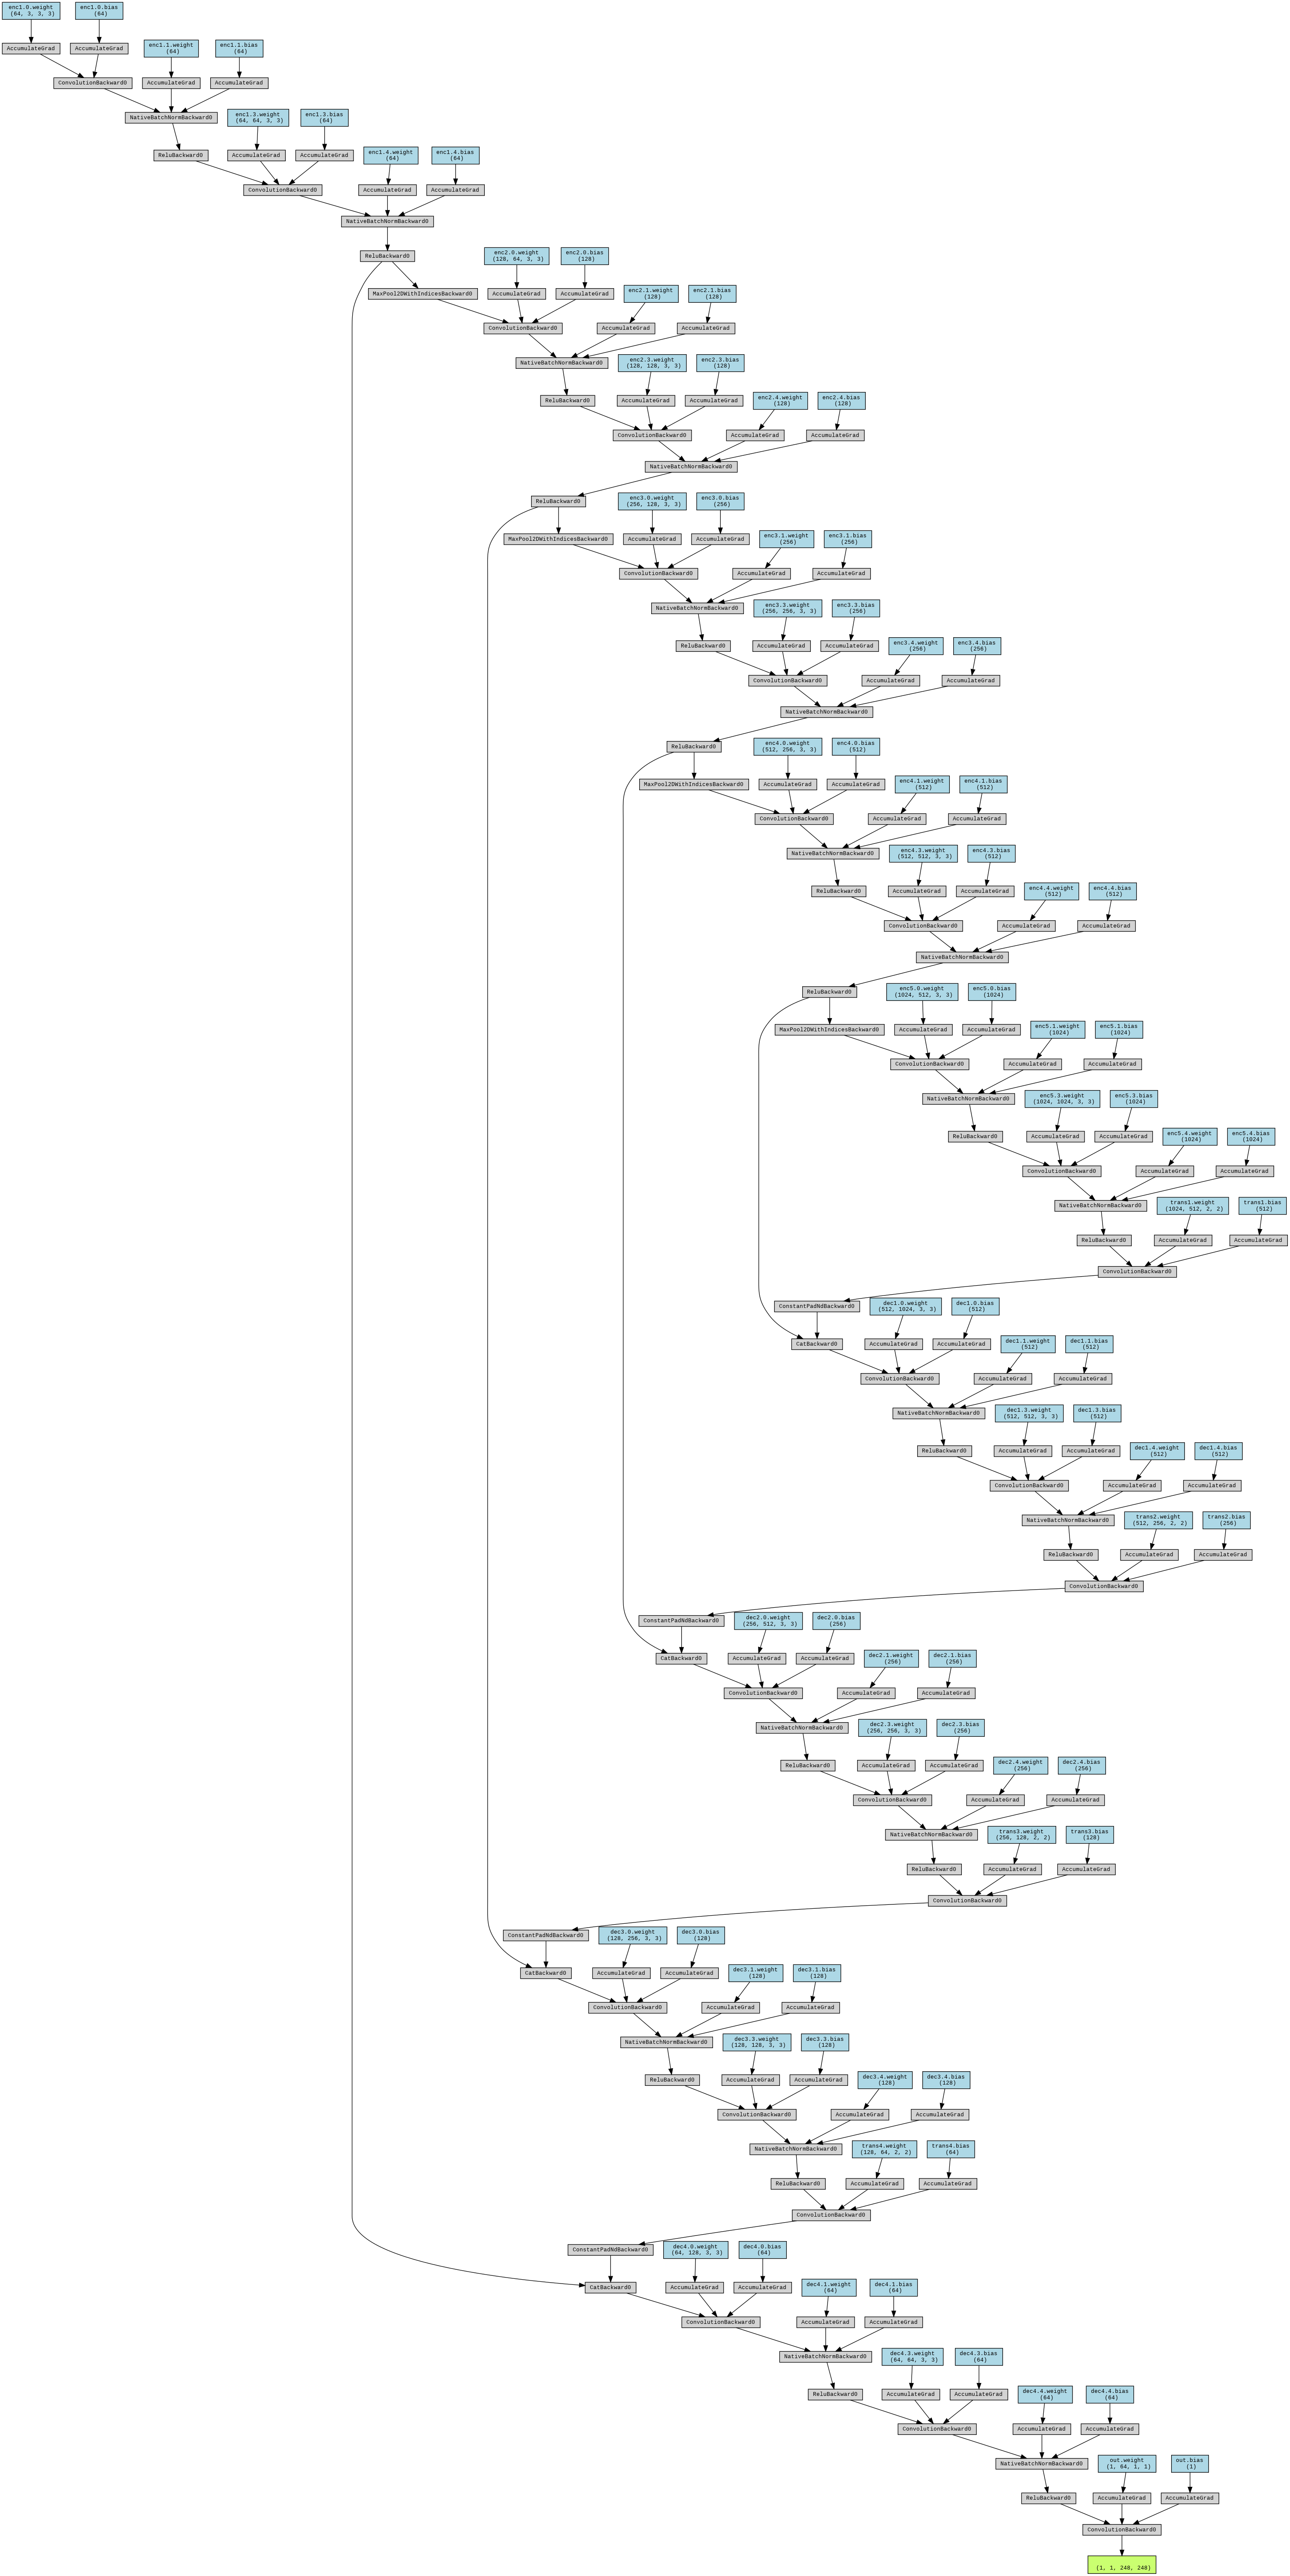

In [ ]:
from torchviz import make_dot

sample_input = torch.rand(1,3,256,256)  # b,c,h,w
output = model(sample_input)
dot = make_dot(output, params = dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')

from IPython.display import Image
Image('model_architecture.png')

## Step 4: Model Training:

4.a. Prerequisites for the training loop:

- Method to stop the training : Early stopping
- Metric: Dice coefficient

Early stoppping:

This is needed to stop the training if the validation accuracy doesn't increase for a while, or the validation loss doesn't decrease for a while. Also we need to save the model if the dice score improves.

In [ ]:
save_path = '/content/drive/MyDrive/naamii/saved_model'
os.makedirs(save_path, exist_ok=True)

In [ ]:
class EarlyStoppingAndSave:
    def __init__(self, patience=5, min_delta=0.001, save_path=None, model=None):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = None
        self.best_dice_score = None
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path
        self.model = model

    def check_early_stop(self, val_loss, dice_score, epoch):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.best_dice_score = dice_score
            self.save_model(epoch)
        elif (val_loss > self.best_val_loss - self.min_delta) and (dice_score <= self.best_dice_score + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping activated! Best Val Loss: {self.best_val_loss}, Best Dice Score: {self.best_dice_score}")
                self.early_stop = True
        else:
            self.best_val_loss = min(val_loss, self.best_val_loss)
            self.best_dice_score = max(dice_score, self.best_dice_score)
            self.counter = 0
            self.save_model(epoch)

    def save_model(self, epoch):
        # Save the model if it's the best one so far
        model_save_path = os.path.join(self.save_path, f'best_model_epoch_{epoch+1}.pth')
        torch.save(self.model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")

Lets also calculate the dice coefficient.

In [ ]:
# Dice Coefficient Calculation
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()  # Binarize predictions
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum() + 1e-6)
    return dice

###4.b. Training Loop:

The training loop consists of many iterations of prediction and backpropagation for the given number of epochs.

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

In [ ]:
# Training for one epoch
def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0.0

    for image, mask in tqdm(train_dataloader, desc="Training", leave=False):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        output = F.interpolate(output, size=mask.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * image.size(0)
        num_train_samples += image.size(0)

    avg_train_loss = running_train_loss / num_train_samples
    return avg_train_loss

###4.c. Validation loop:

Similar to training loop but model is in evaluation mode, and no gradient calculation is done.

In [ ]:
# Validation for one epoch, returns loss and dice score
def validate_one_epoch(model, val_dataloader, criterion, device):
    model.eval()
    running_val_loss = 0.0
    running_dice_score = 0.0
    num_val_samples = 0.0

    with torch.no_grad():
        for image, mask in tqdm(val_dataloader, desc="Validation", leave=False):
            image, mask = image.to(device), mask.to(device)
            output = model(image)
            output = F.interpolate(output, size=mask.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(output, mask)
            dice_score = dice_coefficient(output, mask)

            running_val_loss += loss.item() * image.size(0)
            running_dice_score += dice_score.item() * image.size(0)
            num_val_samples += image.size(0)

    avg_val_loss = running_val_loss / num_val_samples
    avg_dice_score = running_dice_score / num_val_samples

    return avg_val_loss, avg_dice_score

### Main Loop:

This is the outer loop (that runs for certain epochs) that does the following:
1. Calls both functions (train and validation loop) in each epoch.
  * Executes inner loop by iterating over dataloader.
2. Keep track of both losses, and dice score to be plotted later.

In [ ]:
# Main training function with early stopping and saving model
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device, patience=5):
    train_losses = []
    val_losses = []
    dice_scores = []
    early_stopping = EarlyStoppingAndSave(patience=patience, save_path=save_path, model=model)

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        train_losses.append(train_loss)

        val_loss, dice_score = validate_one_epoch(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        dice_scores.append(dice_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice Score: {dice_score:.4f}")

        # Check for early stopping and save model if the dice score improves
        early_stopping.check_early_stop(val_loss, dice_score, epoch)

        if early_stopping.early_stop:
            print("Training stopped early.")
            break

    return train_losses, val_losses, dice_scores

###4.d. Hyperparameters and Optimizers:

Lets specify learning rate, number of epochs, optimizer, and loss function ( `Binary CrossEntropy Loss`).

In [ ]:
learning_rate = 0.001
num_epochs = 50    # a large number to facilitate early stopping

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Lets not forget to load some of the tensors (that may have been loaded in CPU) to the GPU.

In [ ]:
model = model.to(device)

In [ ]:
import torch.optim as optim

Training the model by calling the above function:

In [ ]:
train_losses, val_losses, dice_scores = train_model(
    model=model,
    train_dataloader=dataloader_train,
    val_dataloader=dataloader_val,
    optimizer=optim.Adam(model.parameters(), lr=learning_rate),
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=10  # Patience for early stopping
)

Training: 100%|██████████| 200/200 [15:46<00:00,  4.55s/it]
                                                           
Validation: 100%|██████████| 50/50 [03:35<00:00,  4.35s/it]
                                                           

Epoch [1/50], Train Loss: 0.3605, Val Loss: 0.3592, Dice Score: 0.4516


Epochs:   2%|▏         | 1/50 [19:22<15:49:01, 1162.07s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_1.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.47it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.43it/s]
                                                           

Epoch [2/50], Train Loss: 0.3243, Val Loss: 0.3201, Dice Score: 0.3986


Epochs:   4%|▍         | 2/50 [20:22<6:51:20, 514.18s/it]  

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_2.pth



Training: 100%|██████████| 200/200 [00:53<00:00,  3.61it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:05<00:00,  8.43it/s]
                                                           

Epoch [3/50], Train Loss: 0.3139, Val Loss: 0.2967, Dice Score: 0.2802


Epochs:   6%|▌         | 3/50 [21:23<4:00:34, 307.11s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_3.pth



Training: 100%|██████████| 200/200 [00:53<00:00,  3.73it/s]
                                                           
Epochs:   8%|▊         | 4/50 [22:23<2:40:37, 209.51s/it]

Epoch [4/50], Train Loss: 0.3064, Val Loss: 0.3024, Dice Score: 0.3683



Training: 100%|██████████| 200/200 [00:53<00:00,  3.65it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.63it/s]
                                                           

Epoch [5/50], Train Loss: 0.2985, Val Loss: 0.2952, Dice Score: 0.3756


Epochs:  10%|█         | 5/50 [23:23<1:56:46, 155.69s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_5.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.61it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:05<00:00,  8.42it/s]
                                                           

Epoch [6/50], Train Loss: 0.2913, Val Loss: 0.2889, Dice Score: 0.3717


Epochs:  12%|█▏        | 6/50 [24:24<1:30:31, 123.43s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_6.pth



Training: 100%|██████████| 200/200 [00:53<00:00,  3.64it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]
                                                           

Epoch [7/50], Train Loss: 0.2830, Val Loss: 0.2860, Dice Score: 0.3824


Epochs:  14%|█▍        | 7/50 [25:24<1:13:43, 102.86s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_7.pth



Training: 100%|██████████| 200/200 [00:53<00:00,  3.65it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.27it/s]
                                                           

Epoch [8/50], Train Loss: 0.2770, Val Loss: 0.2777, Dice Score: 0.4480


Epochs:  16%|█▌        | 8/50 [26:25<1:02:33, 89.38s/it] 

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_8.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.50it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:05<00:00,  8.60it/s]
                                                           

Epoch [9/50], Train Loss: 0.2681, Val Loss: 0.2798, Dice Score: 0.5094


Epochs:  18%|█▊        | 9/50 [27:26<55:01, 80.53s/it]  

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_9.pth



Training: 100%|██████████| 200/200 [00:53<00:00,  3.70it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.73it/s]
                                                           

Epoch [10/50], Train Loss: 0.2625, Val Loss: 0.2739, Dice Score: 0.4931


Epochs:  20%|██        | 10/50 [28:27<49:34, 74.37s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_10.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.61it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.28it/s]
                                                           

Epoch [11/50], Train Loss: 0.2587, Val Loss: 0.2590, Dice Score: 0.4984


Epochs:  22%|██▏       | 11/50 [29:28<45:46, 70.42s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_11.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.47it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.39it/s]
                                                           

Epoch [12/50], Train Loss: 0.2527, Val Loss: 0.2661, Dice Score: 0.5216


Epochs:  24%|██▍       | 12/50 [30:29<42:44, 67.48s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_12.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.70it/s]
                                                           
Epochs:  26%|██▌       | 13/50 [31:30<40:22, 65.47s/it]

Epoch [13/50], Train Loss: 0.2420, Val Loss: 0.2648, Dice Score: 0.5210



Training: 100%|██████████| 200/200 [00:54<00:00,  3.67it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.25it/s]
                                                           

Epoch [14/50], Train Loss: 0.2323, Val Loss: 0.2665, Dice Score: 0.5239


Epochs:  28%|██▊       | 14/50 [32:31<38:27, 64.09s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_14.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.48it/s]
                                                           
Epochs:  30%|███       | 15/50 [33:32<36:50, 63.16s/it]

Epoch [15/50], Train Loss: 0.2221, Val Loss: 0.2844, Dice Score: 0.4829



Training: 100%|██████████| 200/200 [00:54<00:00,  3.65it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.50it/s]
                                                           

Epoch [16/50], Train Loss: 0.2126, Val Loss: 0.2824, Dice Score: 0.5337


Epochs:  32%|███▏      | 16/50 [34:32<35:24, 62.49s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_16.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.67it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]
                                                           

Epoch [17/50], Train Loss: 0.2039, Val Loss: 0.2695, Dice Score: 0.5848


Epochs:  34%|███▍      | 17/50 [35:34<34:13, 62.21s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_17.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.40it/s]
                                                           
Epochs:  36%|███▌      | 18/50 [36:35<33:00, 61.89s/it]

Epoch [18/50], Train Loss: 0.1969, Val Loss: 0.3016, Dice Score: 0.5821



Training: 100%|██████████| 200/200 [00:54<00:00,  3.60it/s]
                                                           
Epochs:  38%|███▊      | 19/50 [37:35<31:43, 61.41s/it]

Epoch [19/50], Train Loss: 0.1863, Val Loss: 0.3731, Dice Score: 0.5058



Training: 100%|██████████| 200/200 [00:54<00:00,  3.65it/s]
                                                           
Epochs:  40%|████      | 20/50 [38:36<30:35, 61.19s/it]

Epoch [20/50], Train Loss: 0.1841, Val Loss: 0.4319, Dice Score: 0.4569



Training: 100%|██████████| 200/200 [00:54<00:00,  3.64it/s]
                                                           
Epochs:  42%|████▏     | 21/50 [39:37<29:34, 61.21s/it]

Epoch [21/50], Train Loss: 0.1727, Val Loss: 0.3896, Dice Score: 0.5289



Training: 100%|██████████| 200/200 [00:55<00:00,  3.27it/s]
                                                           
Epochs:  44%|████▍     | 22/50 [40:40<28:46, 61.67s/it]

Epoch [22/50], Train Loss: 0.1655, Val Loss: 0.3276, Dice Score: 0.5657



Training: 100%|██████████| 200/200 [00:55<00:00,  3.51it/s]
                                                           
Epochs:  46%|████▌     | 23/50 [41:41<27:41, 61.55s/it]

Epoch [23/50], Train Loss: 0.1555, Val Loss: 0.3438, Dice Score: 0.5726



Training: 100%|██████████| 200/200 [00:54<00:00,  3.63it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]
                                                           

Epoch [24/50], Train Loss: 0.1486, Val Loss: 0.3159, Dice Score: 0.6134


Epochs:  48%|████▊     | 24/50 [42:43<26:42, 61.64s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_24.pth



Training: 100%|██████████| 200/200 [00:54<00:00,  3.60it/s]
                                                           
Epochs:  50%|█████     | 25/50 [43:45<25:40, 61.61s/it]

Epoch [25/50], Train Loss: 0.1379, Val Loss: 0.3545, Dice Score: 0.6056



Training: 100%|██████████| 200/200 [00:54<00:00,  3.46it/s]
                                                           
Epochs:  52%|█████▏    | 26/50 [44:46<24:34, 61.42s/it]

Epoch [26/50], Train Loss: 0.1314, Val Loss: 0.3342, Dice Score: 0.5947



Training: 100%|██████████| 200/200 [00:54<00:00,  3.62it/s]
                                                           
Epochs:  54%|█████▍    | 27/50 [45:47<23:29, 61.30s/it]

Epoch [27/50], Train Loss: 0.1242, Val Loss: 0.5744, Dice Score: 0.5228



Training: 100%|██████████| 200/200 [00:54<00:00,  3.64it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]
                                                           

Epoch [28/50], Train Loss: 0.1227, Val Loss: 0.3366, Dice Score: 0.6336


Epochs:  56%|█████▌    | 28/50 [46:49<22:34, 61.57s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_28.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.44it/s]
                                                           
Epochs:  58%|█████▊    | 29/50 [47:51<21:36, 61.74s/it]

Epoch [29/50], Train Loss: 0.1190, Val Loss: 0.3455, Dice Score: 0.6133



Training: 100%|██████████| 200/200 [00:55<00:00,  3.47it/s]
                                                           
Epochs:  60%|██████    | 30/50 [48:52<20:32, 61.62s/it]

Epoch [30/50], Train Loss: 0.1125, Val Loss: 0.3358, Dice Score: 0.6252



Training: 100%|██████████| 200/200 [00:54<00:00,  3.62it/s]
                                                           
Epochs:  62%|██████▏   | 31/50 [49:54<19:29, 61.57s/it]

Epoch [31/50], Train Loss: 0.1078, Val Loss: 0.3183, Dice Score: 0.6344



Training: 100%|██████████| 200/200 [00:54<00:00,  3.62it/s]
                                                           
Epochs:  64%|██████▍   | 32/50 [50:55<18:24, 61.37s/it]

Epoch [32/50], Train Loss: 0.1029, Val Loss: 0.3412, Dice Score: 0.6343



Training: 100%|██████████| 200/200 [00:54<00:00,  3.40it/s]
                                                           
Epochs:  66%|██████▌   | 33/50 [51:56<17:22, 61.31s/it]

Epoch [33/50], Train Loss: 0.1014, Val Loss: 0.3570, Dice Score: 0.6248



Training: 100%|██████████| 200/200 [00:55<00:00,  3.38it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]
                                                           

Epoch [34/50], Train Loss: 0.1014, Val Loss: 0.3220, Dice Score: 0.6393


Epochs:  68%|██████▊   | 34/50 [52:58<16:24, 61.53s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_34.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.56it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s]
                                                           

Epoch [35/50], Train Loss: 0.1023, Val Loss: 0.3304, Dice Score: 0.6618


Epochs:  70%|███████   | 35/50 [54:01<15:30, 62.02s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_35.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.58it/s]
                                                           
Epochs:  72%|███████▏  | 36/50 [55:04<14:30, 62.14s/it]

Epoch [36/50], Train Loss: 0.1011, Val Loss: 0.3214, Dice Score: 0.6513



Training: 100%|██████████| 200/200 [00:55<00:00,  3.36it/s]
                                                           
Epochs:  74%|███████▍  | 37/50 [56:06<13:27, 62.14s/it]

Epoch [37/50], Train Loss: 0.0952, Val Loss: 0.3405, Dice Score: 0.6333



Training: 100%|██████████| 200/200 [00:55<00:00,  3.48it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]
                                                           

Epoch [38/50], Train Loss: 0.0919, Val Loss: 0.3282, Dice Score: 0.6644


Epochs:  76%|███████▌  | 38/50 [57:08<12:26, 62.23s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_38.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.55it/s]
                                                           
Epochs:  78%|███████▊  | 39/50 [58:11<11:25, 62.34s/it]

Epoch [39/50], Train Loss: 0.0947, Val Loss: 0.3451, Dice Score: 0.6327



Training: 100%|██████████| 200/200 [00:55<00:00,  3.56it/s]
                                                           
Epochs:  80%|████████  | 40/50 [59:13<10:22, 62.27s/it]

Epoch [40/50], Train Loss: 0.0997, Val Loss: 0.3330, Dice Score: 0.6421



Training: 100%|██████████| 200/200 [00:55<00:00,  3.52it/s]
                                                           
Epochs:  82%|████████▏ | 41/50 [1:00:15<09:19, 62.17s/it]

Epoch [41/50], Train Loss: 0.0921, Val Loss: 0.3170, Dice Score: 0.6547



Training: 100%|██████████| 200/200 [00:55<00:00,  3.44it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]
                                                           

Epoch [42/50], Train Loss: 0.0882, Val Loss: 0.3383, Dice Score: 0.6762


Epochs:  84%|████████▍ | 42/50 [1:01:17<08:17, 62.20s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_42.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.60it/s]
                                                           
Epochs:  86%|████████▌ | 43/50 [1:02:19<07:14, 62.09s/it]

Epoch [43/50], Train Loss: 0.0843, Val Loss: 0.3341, Dice Score: 0.6670



Training: 100%|██████████| 200/200 [00:55<00:00,  3.52it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  7.27it/s]
                                                           

Epoch [44/50], Train Loss: 0.0819, Val Loss: 0.3241, Dice Score: 0.6775


Epochs:  88%|████████▊ | 44/50 [1:03:21<06:13, 62.21s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_44.pth



Training: 100%|██████████| 200/200 [00:55<00:00,  3.40it/s]
                                                           
Epochs:  90%|█████████ | 45/50 [1:04:24<05:11, 62.39s/it]

Epoch [45/50], Train Loss: 0.0811, Val Loss: 0.3449, Dice Score: 0.6546



Training: 100%|██████████| 200/200 [00:55<00:00,  3.36it/s]
                                                           
Epochs:  92%|█████████▏| 46/50 [1:05:26<04:08, 62.15s/it]

Epoch [46/50], Train Loss: 0.0807, Val Loss: 0.3567, Dice Score: 0.6619



Training: 100%|██████████| 200/200 [00:55<00:00,  3.53it/s]
                                                           
Epochs:  94%|█████████▍| 47/50 [1:06:28<03:06, 62.01s/it]

Epoch [47/50], Train Loss: 0.0807, Val Loss: 0.3610, Dice Score: 0.6665



Training: 100%|██████████| 200/200 [00:55<00:00,  3.60it/s]
                                                           
Epochs:  96%|█████████▌| 48/50 [1:07:30<02:03, 62.00s/it]

Epoch [48/50], Train Loss: 0.0814, Val Loss: 0.3171, Dice Score: 0.6698



Training: 100%|██████████| 200/200 [00:55<00:00,  3.60it/s]
                                                           
Epochs:  98%|█████████▊| 49/50 [1:08:32<01:02, 62.07s/it]

Epoch [49/50], Train Loss: 0.0818, Val Loss: 0.3639, Dice Score: 0.6515



Training: 100%|██████████| 200/200 [00:55<00:00,  3.28it/s]
                                                           
Validation: 100%|██████████| 50/50 [00:06<00:00,  8.24it/s]
                                                           

Epoch [50/50], Train Loss: 0.0818, Val Loss: 0.3141, Dice Score: 0.6904


Epochs: 100%|██████████| 50/50 [1:09:34<00:00, 83.49s/it]

Model saved at /content/drive/MyDrive/naamii/saved_model/best_model_epoch_50.pth


Lets visualize the loss curve:

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = [points[0]]  # Initialize with first point
    for point in points[1:]:
        smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
    return smoothed_points

In [ ]:
def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    smoothed_val_losses = smooth_curve(val_losses)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, smoothed_val_losses, 'r', label='Validation Loss (smoothed)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, max(train_losses + val_losses) * 1.1)
    plt.show()

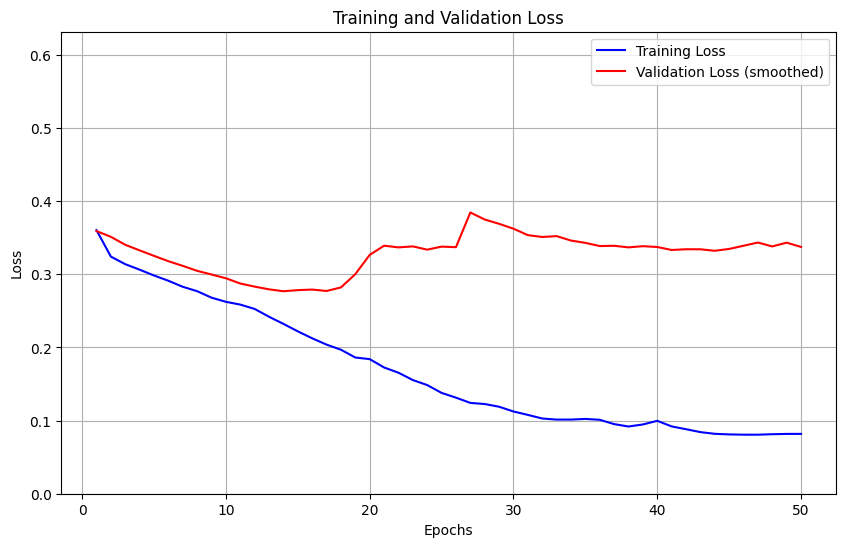

In [ ]:
plot_loss_curve(train_losses, val_losses)

## Model Evaluation:

Evaluation refers to the use of different evaluation metrics to understand the model's performance. It is usually done in the `holdout dataset` or `test dataset`.

In our case, the binary classification of pixels is done in order to create a ground truth mask. Thus, model may perform any of the four cases:
- Predict actual positive class as positive (True Positive or TP)
- Predict actual negative class as positive (False Positive or FP)
- Predict actual positive class as negative (False Negative or FN)
- Predict actual negative class as negative (True Positive or TN)

This can be made clear with the following figure:


<center>

<img src="https://drive.google.com/uc?export=view&id=1IUxU2QcIZ6bLfH_FaAld0WTwsnkX26WW" alt="Contains classification metric" height="400" width="800">

Fig: Understanding confusion matrix in Binary classification task

</center>

In the above figure, the first rectangle (blue without overlap) represent the actual positive class (which may be predicted by model as positive or negative). And the second rectangle (yellow without overlap) represent the predicted positive class (which may include the actual positive or negative class).
- The overlapping green region is an actual positive, also predicted by model as positve. So it is TP.
- The blue region is an actual positive but the model didn't predict it to be positive (i.e. model predicted it to be negative). So, it is FN.
- The yellow region is an actual negative but the model classified it as positive. So, it is FP
- The remaining white region is an actual negative, and the model classified it as negative. So, it is TN.

## Evaluation metrics:

1. $Precision = {TP \over TP+FP}$
  
- Tells us how many of the positive predictions made by the model are actually correct.
- Also called accuracy for positive class prediction.
- Important when minimizing false positives out of all positive predictions is important.
- Example: In sentencing a suspect to a prison, we want to be entirely sure if s/he is guilty because falsely incarcenating someone has a very high cost. (The sole principle of Justice system is that it is considered better to leave out 100 criminals than to falsely accuse  1 innocent person)

\

2. $Recall (Sensitivity) (TPR) = {TP \over TP+FN}$

- Tells us how much of the actual positive instances are correctly identified by the model.
- Also called confidence of the model in predicting positive instances.
- Suitable when we want to identify as many positive samples as possible.
- In disease diagnostics, we want to find all risks even though the cases are not that serious. (Even if a healthy person is identified as a risk, he can always go to an actual doctor and rerun the tests. It's more dangerous to leave out the possible risky patients)

\

3. $Accuracy = {Correct-prediction \over Total-samples} = {TP+TN \over TP+FP+FN+TN}$

- Tells us if the model classified samples (of both classes) correctly.
- Also called `RAND Index` or Combined accuracy.
- Not suitable for imbalanced dataset (datasets where there are more samples in 1 class than the others)

\

4. $Specificity(TNR) = {TN \over FP+TN}$

- Tells us how much actual negative instances are correctly identified by the model. `Similar to recall, but for negative class`
- Suitable when identifying negative items are important.
- Example: (Refer to example for Precision): We want to maximize the chance of classifying innocent people as innocent. That way True Negatives (TN) will be identified, ensuring lower false incarcenation (Low False positives).

\

5. $FPR = {FP \over FP + TN}$

- Tells us how much actual negatives are falsely identified by the model.
- Also called model's inaccuracy in classifying negative as negative,
- Suitable to find (and thus minimize) false positives (FP)
-  Example: (Refer to example for Precision)

\

**Note that FPR and TPR are used to plot AUC curve**
- FPR in X-axis, TPR(sensitivity) in Y-axis.
- If the area under the curve is high, the model is better ar detecting True Positives (TP) and mminimizing False Positives (FP).

\

6.  $IoU = {TP \over TP + FP + FN}$

- Also called Jaccard index or Intersection over Union.
- It is the area of the overlap over union (of the predicted segmentation and the ground truth.)
- Gives equal weightage to TP and FP. (If the model has high FP, the score decreases. Thus False positives are penalized.)

\

7.  $F1 Score = {2 (Precision * Recall) \over Precision + Recall}$
- Maximizes both Precision and Recall independently:
  
  - If precision is low, the model's accuracy is low for positive class. (High FP, high FPR)
  - If recall is low, the model is leaving out large samples of actual positive class. (Actual positives might be predicted as negatives, so high FN, high FNR)

- Harmonic mean gives more weight to the lower values. Thus if either of Recall or Precision is low, the harmomic mean will be high. Thus the only way to maximize F1 score is to maximize both precision as well as recall.

\

* $ Dice Coefficient = {2 * TP \over 2*TP + FP + FN}$
  - Same thing as F1 Score
  - More weight given to TP, so even if the model has high FP, the score doesn't change as much. Thus False positives are not penalized like in IoU. (Minimizing FP is not the biggest concern, but maximizing TP is)


## Model performance:

Lets initialize the model architecture to load the trained weights

In [ ]:
model = UNet(in_channels=3, out_channels=1)

The trained model is saved in Google drive, so we load the saved model as:

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/naamii/saved_model/best_model_epoch_50.pth'))

<ipython-input-61-9053e7386f50>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/naamii/saved_model/best_model_epoch

<All keys matched successfully>

Lets load the tensors to the current device.

To make an inference, we put the model in evaluation mode, and disable the gradient calculation.

* `model.eval()` is done to change the behavior of layers such as 'BatchNorm' and 'Dropout'. For example, Our model 'U-Net' consists of dual convolution, which consists of batchnorm2d layers. The behaviour of this layer has to be changed to ensure it predicts correctly during evaluation.

* `torch.no_grad()` is done to prevent PyTorch from storing gradients, thus freeing up memory.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = model.to(device)
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

In [ ]:
def dice_score(preds, targets):
    smooth=1e-6
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

In [ ]:
def display_image_gt_pred(image_tensor, ground_truth_tensor, predictions_tensor, dice_score, idx, title):
    image_pil = TF.to_pil_image(image_tensor)
    ground_truth_pil = TF.to_pil_image(ground_truth_tensor)
    predictions_pil = TF.to_pil_image(predictions_tensor)

    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.title(f"Image {idx + 1}")
    plt.imshow(image_pil)

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth {idx + 1}")
    plt.imshow(ground_truth_pil, cmap='gray')

    # Display prediction mask with Dice score
    plt.subplot(1, 3, 3)
    plt.title(f"Prediction {idx + 1} (Dice: {dice_score:.4f})")
    plt.imshow(predictions_pil, cmap='gray')

    plt.suptitle(title)


To sort and extract the best and worst instances, lets create a list called `results`. It is not just a simple list, but contains dictionaries. Each dictionary contains the following key value pairs:
1. image: original image tensor of shape [c,h,w]
2. ground truth: tensor of gt mask of shape [h,w]
3. prediction: tensor of mask tensor (after applying sigmoid and thresholding, to creata a binary mask)
4. dice score: a float value of dice score between predicted mask and ground truth mask.

In [ ]:
# Initialize list to store results
results = []

# Perform inference and store images, ground truth, predictions, and dice scores
with torch.no_grad():
    for idx, (images, ground_truths) in enumerate(dataloader_val):
        images = images.to(device)
        ground_truths = ground_truths.to(device)

        # Forward pass through the model
        outputs = model(images)
        outputs = F.interpolate(outputs, size=ground_truths.shape[2:], mode='bilinear', align_corners=False)

        # Apply sigmoid to get probabilities and binarize predictions (threshold at 0.5)
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()

        # Compute dice score for each sample in the batch
        for i in range(len(images)):
            current_dice = dice_score(predictions[i], ground_truths[i])

            # Store image, ground truth, prediction, and dice score in the results list
            results.append({
                'image': images[i].cpu(),
                'ground_truth': ground_truths[i].cpu(),
                'prediction': predictions[i].cpu(),
                'dice_score': current_dice
            })

In [ ]:
results = sorted(results, key=lambda x: x['dice_score'])

Since the results has the dice scores in ascending order, the last 5 dice scores are the highest.


Top 5 Best Predictions:


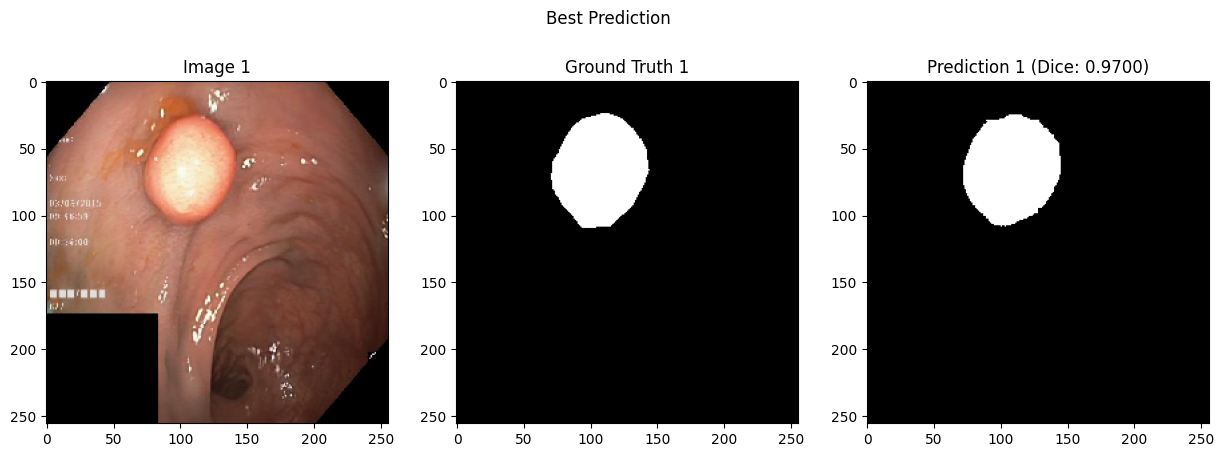

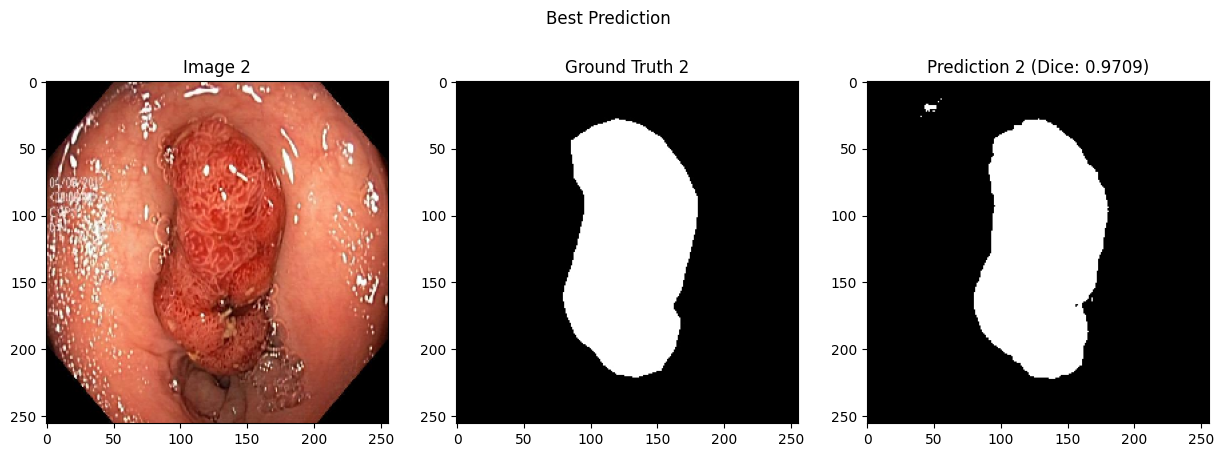

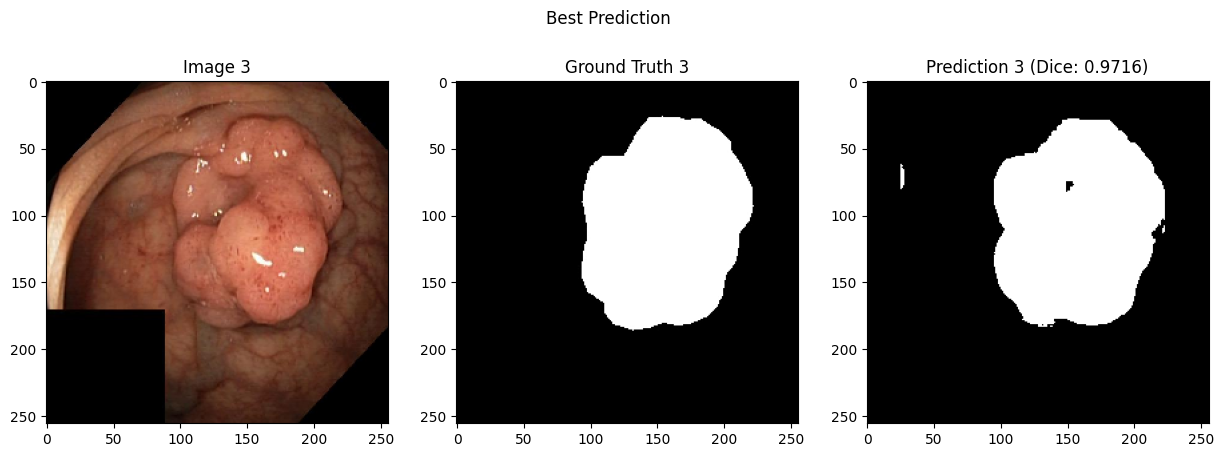

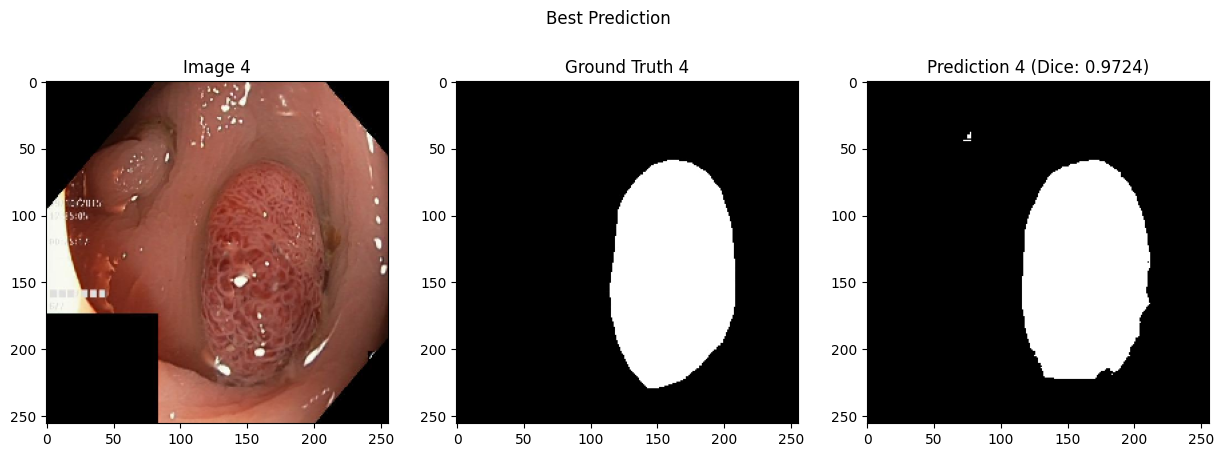

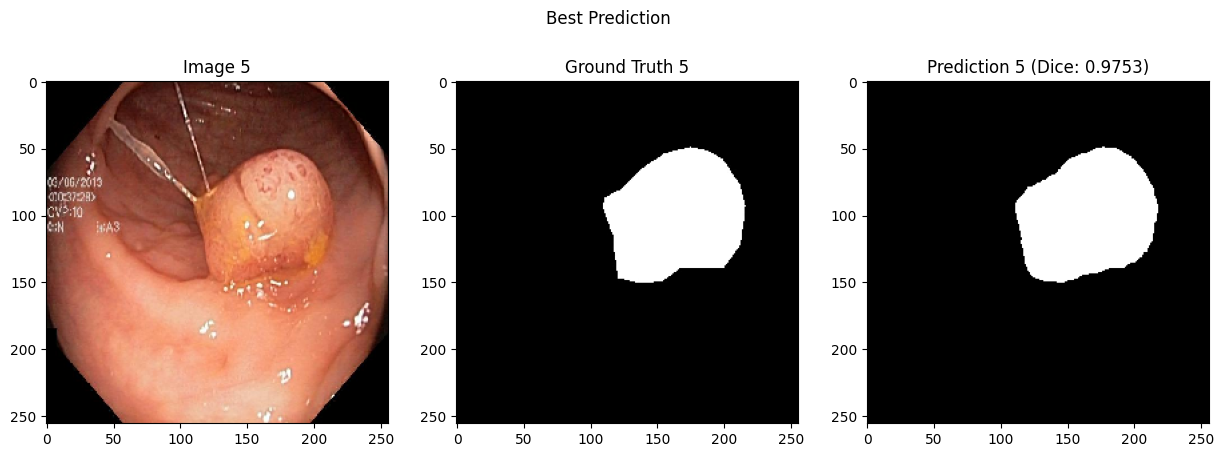

In [ ]:
print("\nTop 5 Best Predictions:")
for idx, result in enumerate(results[-5:]):
    display_image_gt_pred(result['image'], result['ground_truth'], result['prediction'],
                          result['dice_score'], idx, title='Best Prediction')

Top 5 Worst Predictions:


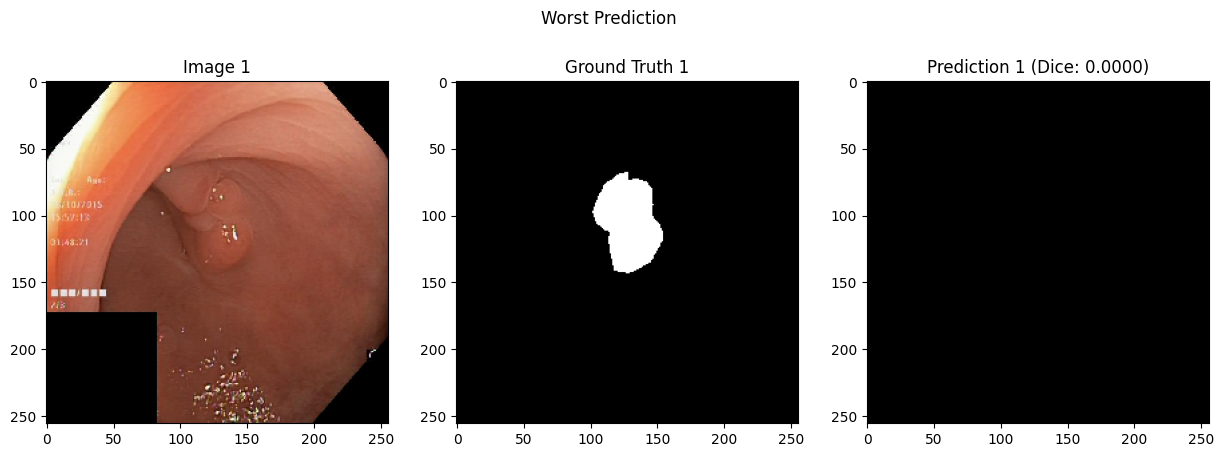

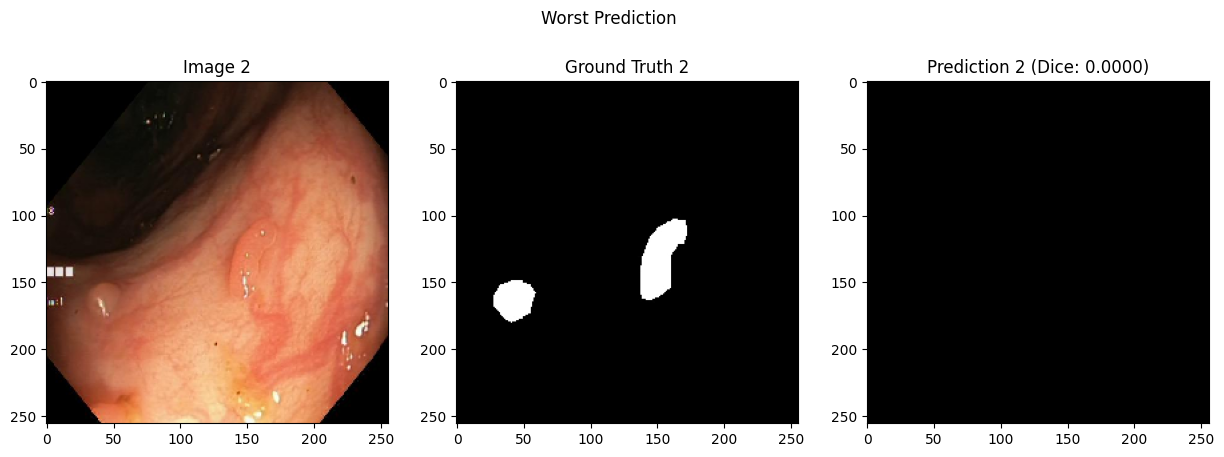

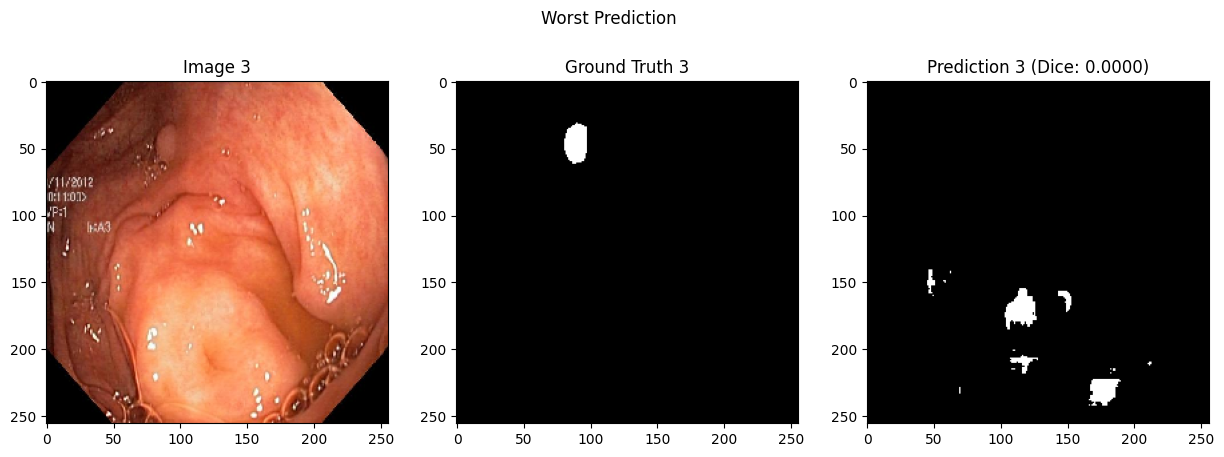

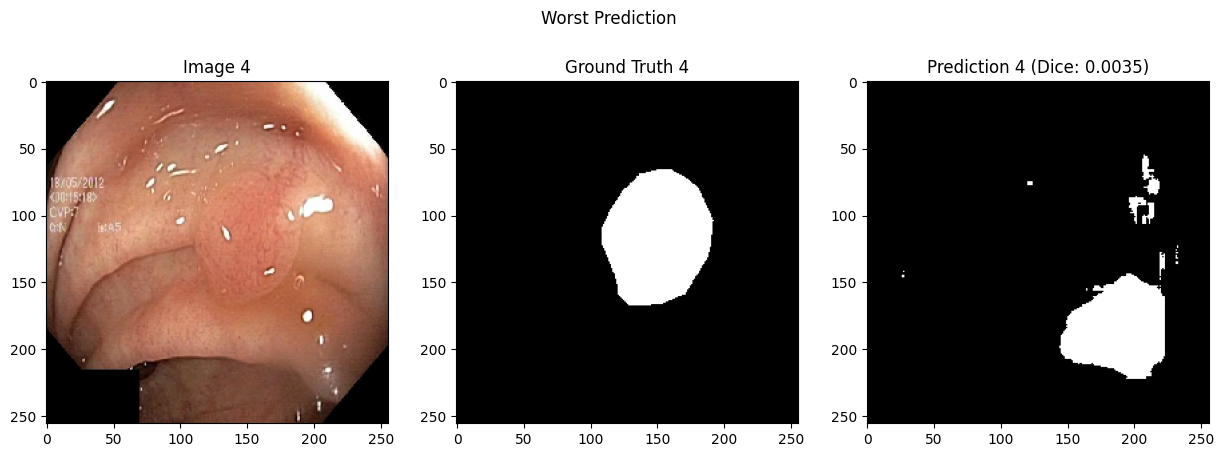

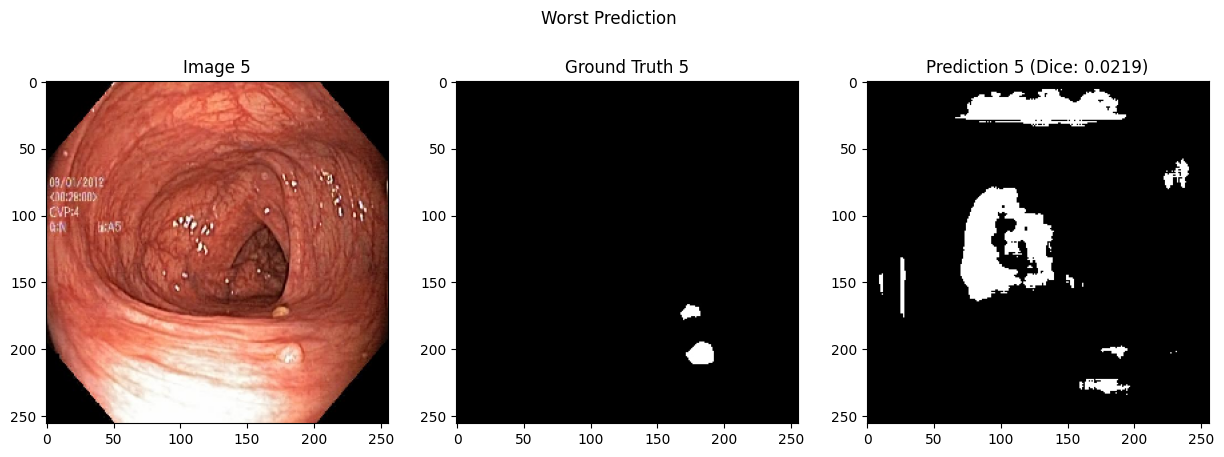

In [ ]:
print("Top 5 Worst Predictions:")
for idx, result in enumerate(results[:5]):
    display_image_gt_pred(result['image'], result['ground_truth'], result['prediction'],
                          result['dice_score'], idx, title='Worst Prediction')


## Inference on Test datasets:

The images on this dataset is completely unseen by the model during the training (unlike the validation set).
The inference on test instances gives us the idea of how the model will perform in the real world data after deployment.  

Lets make the inference similarly..

In [ ]:
model = UNet(in_channels=3, out_channels=1)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/naamii/saved_model/best_model_epoch_50.pth'))

<ipython-input-52-9053e7386f50>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/naamii/saved_model/best_model_epoch

<All keys matched successfully>

In [ ]:
model = model.to(device)
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_

In [ ]:
with torch.no_grad():
    for idx, images in enumerate(dataloader_test):
        test_images = images.to(device)

        test_outputs = model(test_images)

        # Apply sigmoid to get probabilities
        test_predictions = torch.sigmoid(test_outputs)

        # Binarize predictions (threshold at 0.5)
        test_predictions = (test_predictions > 0.5).float()

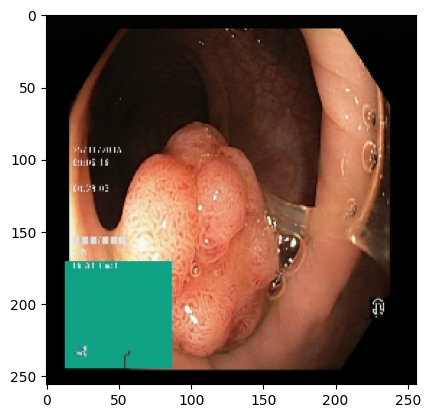

In [ ]:
plt.imshow(TF.to_pil_image(test_images[3]))

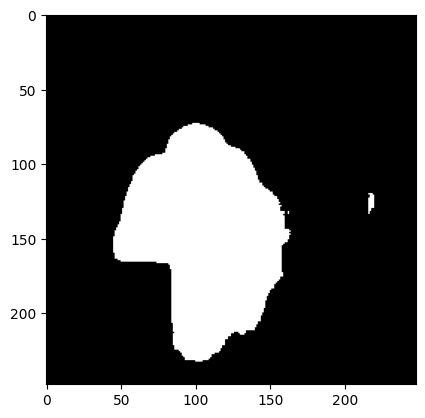

In [ ]:
plt.imshow(TF.to_pil_image(test_predictions[3]), cmap = 'gray')

The prediction seems to be almost correct. The small mask predicted on the right side of the image can be considered as a case of `False positive`. Such false positive cases could guide the doctors to do another round of diagnosis.

## Conclusion:

In conclusion, the endoscopic images have been successfully segmented with an overall dice score of 0.69.

The major challenge was to obtain a higher dice score. Key factors contributing to this challenge include the complexity of the medical images, variations in polyp size and shape, and low contrast between polyps and surrounding tissues. These issues made it difficult for the model to consistently capture fine details in the segmentation process.

For future work, improving the performance could involve augmenting the dataset to help the model better generalize across different variations in the images. Additionally, leveraging more advanced architectures, such as state-of-the-art deep learning models, could enhance accuracy and Dice scores.

This project has practical implications in assisting medical professionals with polyp detection in the gastrointestinal (GI) tract. Computer-aided diagnostic tools like this have the potential to significantly improve the accuracy and efficiency of medical diagnoses, benefiting patient outcomes in the medical domain.